In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.ensemble import BalanceCascade
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_decision_regions
import h5py

%matplotlib inline

KFOLD_SEED = 42

/Users/ytu/.local/share/virtualenvs/rtb-bjTeWfqO/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
input_path = '~/data/biddings.csv'
data = pd.read_csv(input_path)
print(data.shape)

(1000000, 89)


In [3]:
train = data[:800000]
test = data[800000:]

sample = train.sample(frac=1)
features = sample.drop('convert', axis=1).values
labels = sample.convert.ravel()

test_features = test.drop('convert', axis=1).values
test_labels = test.convert.ravel()

### Explore input data

Only ~0.2% of rows have `convert = true`

In [8]:
pd.value_counts(data['convert'])[1]/data.shape[0] * 100

0.1908

#### Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression

Cross validation with mean accuracy as test metric

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

def test_auc(model):
    predicted_scores = model.predict_proba(test_features)[:,1]
    return roc_auc_score(test_labels, predicted_scores)


def train_kfold(classifier, features, labels, n_splits=3, minibatch=False, batch_size=128):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=KFOLD_SEED)
    
#     fprs = []
#     tprs = []
    aucs = []
    test_aucs = []
    
    for train_index, validation_index in kf.split(features):
        train_features, validation_features = features[train_index], features[validation_index]
        train_labels, validation_labels = labels[train_index], labels[validation_index]
        
        if minibatch == True:
            model = sgd_minibatch(classifier, train_features, train_labels, batch_size=batch_size)
        else:
            model = classifier.fit(train_features, train_labels)
        
        predicted_scores = model.predict_proba(validation_features)[:,1]
        
        auc_score = roc_auc_score(validation_labels, predicted_scores)
#         fprs.append(fpr)
#         tprs.append(tpr)
        aucs.append(auc_score)
        test_aucs.append(test_auc(model))
    
    return np.mean(aucs), np.mean(test_aucs)


def sgd_minibatch(classifier, features, labels, batch_size=128):
    n_features = features.shape[0]
    end_index = 0
    n_batches = n_features / batch_size
    print("Minibatch: %0.2f" % n_batches)
    
    batch_index = 0
    while end_index < n_features:
        print("Batch %d" % batch_index)
        next_end = min(end_index + batch_size, n_features)
        feature_batch = features[end_index : next_end]
        end_index = next_end
        
        classifier.partial_fit(features, labels, classes=[0,1])
        batch_index += 1
    
    return classifier


We use ROC_AUC (Receiver operating characteristic area under curve) as the main metric rather than accuracy because the label distribution is highly unbalanced. But since we are using under-sampled data here, we should look at accuracy as well.

#### Establish baseline

In [7]:
lr = LogisticRegression(penalty='l2')
mean_valid_auc, mean_test_auc = train_kfold(lr, features, labels, n_splits=3)
print("validation_auc: %0.3f, test_auc: %0.3f" % (mean_valid_auc, mean_test_auc))

predicted = lr.predict(test_features)
print(f1_score(test_labels, predicted))
print(confusion_matrix(test_labels, predicted))

validation_auc: 0.683, test_auc: 0.711
0.0


/root/.local/share/virtualenvs/RTB-V2Lvgo6A/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[[199623      0]
 [   377      0]]


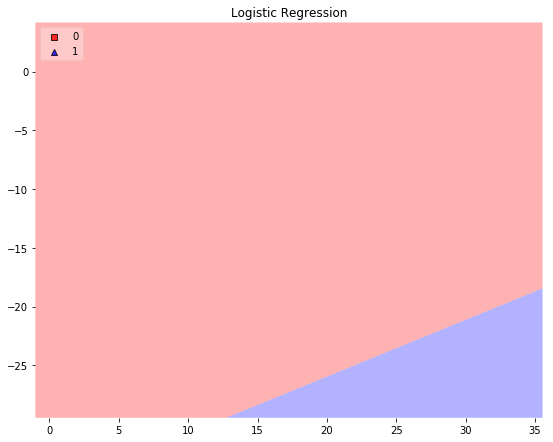

In [24]:
lr.fit(features, labels)

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(20, 16))

not_plotted_values = {}
not_plotted_widths = {}
for i in range(2, 88):
    not_plotted_values[i] = 3
    not_plotted_widths[i] = 1.5

ax = plt.subplot(gs[0, 1])
fig = plot_decision_regions(X=features, y=labels, clf=lr, legend=2,
                            filler_feature_values=not_plotted_values,
                            filler_feature_ranges=not_plotted_widths)
plt.title('Logistic Regression')

plt.show()

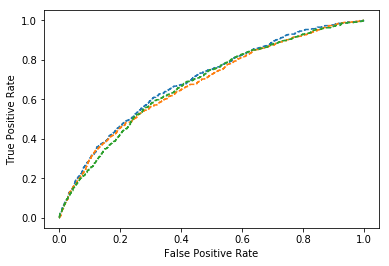

In [117]:
for i in range(3):
    plt.plot(fprs[i], tprs[i], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
    

In [19]:
# Minibatch
sgd = SGDClassifier(loss='log', penalty='l2', max_iter=64)
fprs, tprs, mean_valid_auc, mean_test_auc = train_kfold(sgd, features, labels, n_splits=3,
                                                        minibatch=True, batch_size=256)
print("validation_auc: %0.3f, test_auc: %0.3f" % (mean_valid_auc, mean_test_auc))


Minibatch: 2083.33
Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
B

Batch 829
Batch 830
Batch 831
Batch 832
Batch 833
Batch 834
Batch 835
Batch 836
Batch 837
Batch 838
Batch 839
Batch 840
Batch 841
Batch 842
Batch 843
Batch 844
Batch 845
Batch 846
Batch 847
Batch 848
Batch 849
Batch 850
Batch 851
Batch 852
Batch 853
Batch 854
Batch 855
Batch 856
Batch 857
Batch 858
Batch 859
Batch 860
Batch 861
Batch 862
Batch 863
Batch 864
Batch 865
Batch 866
Batch 867
Batch 868
Batch 869
Batch 870
Batch 871
Batch 872
Batch 873
Batch 874
Batch 875
Batch 876
Batch 877
Batch 878
Batch 879
Batch 880
Batch 881
Batch 882
Batch 883
Batch 884
Batch 885
Batch 886
Batch 887
Batch 888
Batch 889
Batch 890
Batch 891
Batch 892
Batch 893
Batch 894
Batch 895
Batch 896
Batch 897
Batch 898
Batch 899
Batch 900
Batch 901
Batch 902
Batch 903
Batch 904
Batch 905
Batch 906
Batch 907
Batch 908
Batch 909
Batch 910
Batch 911
Batch 912
Batch 913
Batch 914
Batch 915
Batch 916
Batch 917
Batch 918
Batch 919
Batch 920
Batch 921
Batch 922
Batch 923
Batch 924
Batch 925
Batch 926
Batch 927
Batch 928


Batch 1590
Batch 1591
Batch 1592
Batch 1593
Batch 1594
Batch 1595
Batch 1596
Batch 1597
Batch 1598
Batch 1599
Batch 1600
Batch 1601
Batch 1602
Batch 1603
Batch 1604
Batch 1605
Batch 1606
Batch 1607
Batch 1608
Batch 1609
Batch 1610
Batch 1611
Batch 1612
Batch 1613
Batch 1614
Batch 1615
Batch 1616
Batch 1617
Batch 1618
Batch 1619
Batch 1620
Batch 1621
Batch 1622
Batch 1623
Batch 1624
Batch 1625
Batch 1626
Batch 1627
Batch 1628
Batch 1629
Batch 1630
Batch 1631
Batch 1632
Batch 1633
Batch 1634
Batch 1635
Batch 1636
Batch 1637
Batch 1638
Batch 1639
Batch 1640
Batch 1641
Batch 1642
Batch 1643
Batch 1644
Batch 1645
Batch 1646
Batch 1647
Batch 1648
Batch 1649
Batch 1650
Batch 1651
Batch 1652
Batch 1653
Batch 1654
Batch 1655
Batch 1656
Batch 1657
Batch 1658
Batch 1659
Batch 1660
Batch 1661
Batch 1662
Batch 1663
Batch 1664
Batch 1665
Batch 1666
Batch 1667
Batch 1668
Batch 1669
Batch 1670
Batch 1671
Batch 1672
Batch 1673
Batch 1674
Batch 1675
Batch 1676
Batch 1677
Batch 1678
Batch 1679
Batch 1680

Batch 285
Batch 286
Batch 287
Batch 288
Batch 289
Batch 290
Batch 291
Batch 292
Batch 293
Batch 294
Batch 295
Batch 296
Batch 297
Batch 298
Batch 299
Batch 300
Batch 301
Batch 302
Batch 303
Batch 304
Batch 305
Batch 306
Batch 307
Batch 308
Batch 309
Batch 310
Batch 311
Batch 312
Batch 313
Batch 314
Batch 315
Batch 316
Batch 317
Batch 318
Batch 319
Batch 320
Batch 321
Batch 322
Batch 323
Batch 324
Batch 325
Batch 326
Batch 327
Batch 328
Batch 329
Batch 330
Batch 331
Batch 332
Batch 333
Batch 334
Batch 335
Batch 336
Batch 337
Batch 338
Batch 339
Batch 340
Batch 341
Batch 342
Batch 343
Batch 344
Batch 345
Batch 346
Batch 347
Batch 348
Batch 349
Batch 350
Batch 351
Batch 352
Batch 353
Batch 354
Batch 355
Batch 356
Batch 357
Batch 358
Batch 359
Batch 360
Batch 361
Batch 362
Batch 363
Batch 364
Batch 365
Batch 366
Batch 367
Batch 368
Batch 369
Batch 370
Batch 371
Batch 372
Batch 373
Batch 374
Batch 375
Batch 376
Batch 377
Batch 378
Batch 379
Batch 380
Batch 381
Batch 382
Batch 383
Batch 384


Batch 1095
Batch 1096
Batch 1097
Batch 1098
Batch 1099
Batch 1100
Batch 1101
Batch 1102
Batch 1103
Batch 1104
Batch 1105
Batch 1106
Batch 1107
Batch 1108
Batch 1109
Batch 1110
Batch 1111
Batch 1112
Batch 1113
Batch 1114
Batch 1115
Batch 1116
Batch 1117
Batch 1118
Batch 1119
Batch 1120
Batch 1121
Batch 1122
Batch 1123
Batch 1124
Batch 1125
Batch 1126
Batch 1127
Batch 1128
Batch 1129
Batch 1130
Batch 1131
Batch 1132
Batch 1133
Batch 1134
Batch 1135
Batch 1136
Batch 1137
Batch 1138
Batch 1139
Batch 1140
Batch 1141
Batch 1142
Batch 1143
Batch 1144
Batch 1145
Batch 1146
Batch 1147
Batch 1148
Batch 1149
Batch 1150
Batch 1151
Batch 1152
Batch 1153
Batch 1154
Batch 1155
Batch 1156
Batch 1157
Batch 1158
Batch 1159
Batch 1160
Batch 1161
Batch 1162
Batch 1163
Batch 1164
Batch 1165
Batch 1166
Batch 1167
Batch 1168
Batch 1169
Batch 1170
Batch 1171
Batch 1172
Batch 1173
Batch 1174
Batch 1175
Batch 1176
Batch 1177
Batch 1178
Batch 1179
Batch 1180
Batch 1181
Batch 1182
Batch 1183
Batch 1184
Batch 1185

Batch 1840
Batch 1841
Batch 1842
Batch 1843
Batch 1844
Batch 1845
Batch 1846
Batch 1847
Batch 1848
Batch 1849
Batch 1850
Batch 1851
Batch 1852
Batch 1853
Batch 1854
Batch 1855
Batch 1856
Batch 1857
Batch 1858
Batch 1859
Batch 1860
Batch 1861
Batch 1862
Batch 1863
Batch 1864
Batch 1865
Batch 1866
Batch 1867
Batch 1868
Batch 1869
Batch 1870
Batch 1871
Batch 1872
Batch 1873
Batch 1874
Batch 1875
Batch 1876
Batch 1877
Batch 1878
Batch 1879
Batch 1880
Batch 1881
Batch 1882
Batch 1883
Batch 1884
Batch 1885
Batch 1886
Batch 1887
Batch 1888
Batch 1889
Batch 1890
Batch 1891
Batch 1892
Batch 1893
Batch 1894
Batch 1895
Batch 1896
Batch 1897
Batch 1898
Batch 1899
Batch 1900
Batch 1901
Batch 1902
Batch 1903
Batch 1904
Batch 1905
Batch 1906
Batch 1907
Batch 1908
Batch 1909
Batch 1910
Batch 1911
Batch 1912
Batch 1913
Batch 1914
Batch 1915
Batch 1916
Batch 1917
Batch 1918
Batch 1919
Batch 1920
Batch 1921
Batch 1922
Batch 1923
Batch 1924
Batch 1925
Batch 1926
Batch 1927
Batch 1928
Batch 1929
Batch 1930

Batch 560
Batch 561
Batch 562
Batch 563
Batch 564
Batch 565
Batch 566
Batch 567
Batch 568
Batch 569
Batch 570
Batch 571
Batch 572
Batch 573
Batch 574
Batch 575
Batch 576
Batch 577
Batch 578
Batch 579
Batch 580
Batch 581
Batch 582
Batch 583
Batch 584
Batch 585
Batch 586
Batch 587
Batch 588
Batch 589
Batch 590
Batch 591
Batch 592
Batch 593
Batch 594
Batch 595
Batch 596
Batch 597
Batch 598
Batch 599
Batch 600
Batch 601
Batch 602
Batch 603
Batch 604
Batch 605
Batch 606
Batch 607
Batch 608
Batch 609
Batch 610
Batch 611
Batch 612
Batch 613
Batch 614
Batch 615
Batch 616
Batch 617
Batch 618
Batch 619
Batch 620
Batch 621
Batch 622
Batch 623
Batch 624
Batch 625
Batch 626
Batch 627
Batch 628
Batch 629
Batch 630
Batch 631
Batch 632
Batch 633
Batch 634
Batch 635
Batch 636
Batch 637
Batch 638
Batch 639
Batch 640
Batch 641
Batch 642
Batch 643
Batch 644
Batch 645
Batch 646
Batch 647
Batch 648
Batch 649
Batch 650
Batch 651
Batch 652
Batch 653
Batch 654
Batch 655
Batch 656
Batch 657
Batch 658
Batch 659


Batch 1345
Batch 1346
Batch 1347
Batch 1348
Batch 1349
Batch 1350
Batch 1351
Batch 1352
Batch 1353
Batch 1354
Batch 1355
Batch 1356
Batch 1357
Batch 1358
Batch 1359
Batch 1360
Batch 1361
Batch 1362
Batch 1363
Batch 1364
Batch 1365
Batch 1366
Batch 1367
Batch 1368
Batch 1369
Batch 1370
Batch 1371
Batch 1372
Batch 1373
Batch 1374
Batch 1375
Batch 1376
Batch 1377
Batch 1378
Batch 1379
Batch 1380
Batch 1381
Batch 1382
Batch 1383
Batch 1384
Batch 1385
Batch 1386
Batch 1387
Batch 1388
Batch 1389
Batch 1390
Batch 1391
Batch 1392
Batch 1393
Batch 1394
Batch 1395
Batch 1396
Batch 1397
Batch 1398
Batch 1399
Batch 1400
Batch 1401
Batch 1402
Batch 1403
Batch 1404
Batch 1405
Batch 1406
Batch 1407
Batch 1408
Batch 1409
Batch 1410
Batch 1411
Batch 1412
Batch 1413
Batch 1414
Batch 1415
Batch 1416
Batch 1417
Batch 1418
Batch 1419
Batch 1420
Batch 1421
Batch 1422
Batch 1423
Batch 1424
Batch 1425
Batch 1426
Batch 1427
Batch 1428
Batch 1429
Batch 1430
Batch 1431
Batch 1432
Batch 1433
Batch 1434
Batch 1435

#### Examine feature variance

In [8]:
from sklearn.feature_selection import VarianceThreshold

def get_selector(features, threshold=0.8):
    selector = VarianceThreshold(threshold)
    selector.fit(features)
    return selector
#     print("Variances is %s"%selector.variances_)
#     print("After transform is %s"%selector.transform(features))
#     print("The support is %s"%selector.get_support(True))

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

selector = get_selector(features, threshold=0.1)
lr = LogisticRegression(penalty='l1', verbose=1, random_state=KFOLD_SEED)

tree_selector = SelectFromModel(DecisionTreeClassifier(max_features=10))
print("created tree selector")

# tree_selector.fit(features, labels)
clf = Pipeline([
  ('feature_selection', tree_selector),
  ('classification', lr)
])

randomUnderSampler = RandomUnderSampler(ratio={0: 1531*8, 1: 1531}, random_state=KFOLD_SEED)
smote = SMOTE(n_jobs=-1, ratio={0:1531*8, 1:1531*4}, random_state=KFOLD_SEED)
undersampled_train_valid_features, undersampled_train_valid_labels = randomUnderSampler.fit_sample(
    features, labels)

# fprs, tprs, mean_valid_auc, mean_test_auc = over_down_sample_kfold(
#     clf, randomUnderSampler, undersampled_train_valid_features, undersampled_train_valid_labels)

fprs, tprs, mean_valid_auc, mean_test_auc = train_kfold(clf, features, labels, n_splits=3)
print("validation_auc: %0.3f, test_auc: %0.3f" % (mean_valid_auc, mean_test_auc))

created tree selector
[LibLinear][LibLinear][LibLinear]validation_auc: 0.669, test_auc: 0.691


In [10]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(features)
svc = SVC(kernel='rbf', probability=True, max_iter=16, verbose=True)

fprs, tprs, mean_valid_auc, mean_test_auc = train_kfold(svc, scaler.transform(features), labels, n_splits=3)
print("validation_auc: %0.3f, test_auc: %0.3f" % (mean_valid_auc, mean_test_auc))

[LibSVM]

/root/.local/share/virtualenvs/RTB-V2Lvgo6A/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM][LibSVM]validation_auc: 0.482, test_auc: 0.479


#### Over/Down sampling


In [41]:
lr = LogisticRegression(penalty='l2')

def over_down_sample_kfold(classifier, sampler, features, labels, test_size=0.33):
    resampled_train_valid_features, resampled_train_valid_labels = sampler.fit_sample(
        features, labels)

    mean_valid_auc, mean_test_auc = train_kfold(classifier,
        resampled_train_valid_features, resampled_train_valid_labels, n_splits=3)
    
    print("%s, validation_auc: %0.3f, test_auc: %0.3f" % (
        sampler.__class__.__name__, mean_valid_auc, mean_test_auc))
    
    return mean_valid_auc, mean_test_auc
    

We don't want to use `NearMiss` as it overfits

In [7]:
# Down sampling
randomUnderSampler = RandomUnderSampler()
nearMiss = NearMiss(n_jobs=-1)
# Over sampling
# SMOTE is extremely slow due to large negative sample size
# smote = SMOTE(n_jobs=-1)
# randomOversampler = RandomOverSampler()

for sampler in [randomUnderSampler, nearMiss]:
    lr = LogisticRegression(penalty='l2')
    over_down_sample_kfold(lr, sampler, features, labels)


RandomUnderSampler, validation_auc: 0.684, test_auc: 0.699
NearMiss, validation_auc: 0.987, test_auc: 0.575


In [42]:
randomUnderSampler = RandomUnderSampler(ratio={0: 1531*20, 1: 1531}, random_state=KFOLD_SEED)
lr = LogisticRegression(penalty='l2')
over_down_sample_kfold(lr, randomUnderSampler, features, labels)

RandomUnderSampler, validation_auc: 0.682, test_auc: 0.712


(0.6816256516587723, 0.7122140774706033)

In [43]:
randomUnderSampler = RandomUnderSampler(ratio={0: 1531*4, 1: 1531}, random_state=KFOLD_SEED)

smote = SMOTE(n_jobs=-1, random_state=KFOLD_SEED)
undersampled_train_valid_features, undersampled_train_valid_labels = randomUnderSampler.fit_sample(
    features, labels)

lr = LogisticRegression(penalty='l2', random_state=KFOLD_SEED)
over_down_sample_kfold(lr, smote, undersampled_train_valid_features, undersampled_train_valid_labels)


SMOTE, validation_auc: 0.694, test_auc: 0.712


(0.6935503369636562, 0.7117348717806097)

In [203]:
def custom_sampling():
    randomUnderSampler = RandomUnderSampler(ratio={0: 1531*4, 1: 1531}, random_state=KFOLD_SEED)

    smote = SMOTE(n_jobs=-1, random_state=KFOLD_SEED)
    X, y = randomUnderSampler.fit_sample(features, labels)
    X2, y2 = smote.fit_sample(X, y)
    return X2, y2

def sgd_benchmark():
    sgd = SGDClassifier(random_state=KFOLD_SEED,
                        loss='log', penalty='l2', eta0=0.001, learning_rate='invscaling', max_iter=128)
    
    param_grid = {'eta0':[0.0001, 0.001, 0.01, 0.1],
                  'alpha': [0.0001, 0.001, 0.01],
                  'class_weight': [None, 'balanced', {0: 0.2, 1: 0.8}, {0: 0.6, 1: 0.4}, {0: 0.8, 1: 0.2}],
                  'power_t': [0.2, 0.5, 0.8],
                  'max_iter': [64, 128, 256]}
    
    gs = GridSearchCV(estimator=sgd, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2)
    X, y = custom_sampling()
    gs = gs.fit(X, y)
    
    return gs.best_score_, gs.best_params_

sgd_benchmark()

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.0001, max_iter=64,

[CV]  alpha=0.0001, class_weight=None, eta0=0.001, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight=None, eta0=0.001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.0001, class_weight=None, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight=None, eta0=0.001, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.5 


[CV]  alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.0001, class_weight=None, eta0=0.1, max_iter=256, power_t=0.8 
[CV]  alph

[CV]  alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.5 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.2 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.2, total=   0.7s
[CV] alpha=0.0001, 

[CV]  alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.2 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.2 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.2 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.5 
[CV]  alpha=0.0001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, et

[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.

[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.2, 1: 

[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.0001, class_weight

[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0

[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.6, 1: 0.4}, eta0

[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.8 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 

[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.0001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.5 
[CV]  alpha=0.0001, class_weight={0: 0.8, 1: 

[CV]  alpha=0.001, class_weight=None, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.001, class_weight=None, eta0=0.0001, max_iter=128, 

[CV]  alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight=None, eta0=0.01, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight=None, eta0=0.01, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight=None, eta0=0.01, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight=None, eta0=0.01, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, 

[CV]  alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.2 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight

[CV]  alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.5 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.5 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.001, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight

[CV]  alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.2 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.2 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.2 
[CV]  alpha=0.001, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.001, class_weight=balanced, eta0=0.1, m

[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, et

[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.5, total=   0.9s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.01, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=64, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.2, 1: 0.8}, eta0=0.

[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.8, total=   0.3s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=128, power_t=0.8 
[CV]  alpha=0.001, class_weight={0:

[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_

[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.2, total=   0.7s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_iter=256, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.6, 1: 0.4}, eta0=0.1, max_i

[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=128, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.

[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.8 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.2 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=64, power_t=0.5 
[CV]  alpha=0.001, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=

[CV]  alpha=0.01, class_weight=None, eta0=0.0001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.2, total=   0.8s
[CV] alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.2, total=   0.7s
[CV] alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.2, total=   0.7s
[CV] alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.5 
[CV]  alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.5 
[CV]  alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.5, total=   0.8s
[CV] alpha=0.01, class_weight=None, eta0=0.0001, max_iter=256, power_t=0.5

[CV]  alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.5 
[CV]  alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight=None, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight=None, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight=None, eta0=0.01, max_iter=256, power_t=0.2, total=   0.7s
[CV] alpha=0.01, class_weight=None, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, clas

[CV]  alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.5 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.0001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight=

[CV]  alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.5 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight=balanced, eta0=0.01, max_iter=1

[CV]  alpha=0.01, class_weight=balanced, eta0=0.1, max_iter=256, power_t=0.8, total=   0.8s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max_iter=64, power_t=0.5 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.0001, max

[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=128, power_t=0.8, total=   0.5s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.2, total=   0.9s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.2, total=   1.0s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.2, total=   0.9s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.001, max_iter=256, power_t=0.5 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0

[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power_t=0.5 
[CV]  alpha=0.01, class_weight={0: 0.2, 1: 0.8}, eta0=0.1, max_iter=128, power

[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=256, power_t=0.8, total=   1.0s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=256, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=256, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.0001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=64, power_t=0.2, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.001, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0

[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=256, power_t=0.2, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.6, 1: 0.4}, eta0=0.01, max_i

[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.5, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=64, power_t=0.8, total=   0.2s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=128, power_t=0.2, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0001, max_iter=128, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta

[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.5 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.5, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.001, max_iter=256, power_t=0.8, total=   0.7s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.01, max_iter=64, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.0

[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.5 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.5, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.8 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=128, power_t=0.8, total=   0.4s
[CV] alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=256, power_t=0.2 
[CV]  alpha=0.01, class_weight={0: 0.8, 1: 0.2}, eta0=0.1, max_iter=256, po

[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed: 12.3min finished


(0.6972139198282097,
 {'alpha': 0.0001,
  'class_weight': {0: 0.2, 1: 0.8},
  'eta0': 0.01,
  'max_iter': 128,
  'power_t': 0.5})

In [44]:
sgd = SGDClassifier(loss='log', penalty='l2', random_state=KFOLD_SEED,
                    eta0=0.01, learning_rate='invscaling', max_iter=128, alpha=0.0001, power_t=0.5)

over_down_sample_kfold(sgd, smote, undersampled_train_valid_features, undersampled_train_valid_labels)

SMOTE, validation_auc: 0.692, test_auc: 0.712


(0.6915813304105128, 0.7117488858186451)

## Neural Net

In [5]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support

batch_size = 128
num_classes = 2
epochs = 1

features = sample.drop('convert', axis=1).values
labels = sample.convert.ravel()

test_features = test.drop('convert', axis=1).values
test_labels = test.convert.ravel()

def keras_confusion_matrix(test_labels, y_preds):
    m = confusion_matrix(test_labels[:,1], y_preds.argmax(axis=-1))

    print("Confusion Matrix:")
    print("True Negative = %d" % m[0][0])
    print("False Negative = %d" % m[1][0])
    print("True Positive = %d" % m[1][1])
    print("False Positive = %d" % m[0][1])
    

def keras_f1_score(test_labels, y_preds):
    f = f1_score(test_labels[:,1], y_preds.argmax(axis=-1))
    print("f1 score = %0.3f" % f)
    
def keras_precision_recall(test_labels, y_preds):
    precision, recall, fbeta_score, support = precision_recall_fscore_support(
        test_labels[:,1], y_preds.argmax(axis=-1))
    print("Precision = %0.3f, Recall = %0.3f" % (np.mean(precision), np.mean(recall)))
    return precision, recall
    
# convert class vectors to binary class matrices
# X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.33)

# print(y_train.shape, test_labels.shape)
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_valid = keras.utils.to_categorical(y_valid, num_classes)

labels = keras.utils.to_categorical(labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)
print(labels.shape, test_labels.shape)


(800000, 2) (200000, 2)


In [28]:
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(88, kernel_initializer='ones', input_shape=(88,)))
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

history = model.fit(features, labels,
                    batch_size=batch_size,
                    epochs=1,
                    validation_split=0.2,
                    verbose=1)

y_preds = model.predict(test_features, verbose=1)

print("ROC Score = %0.3f" % roc_auc_score(test_labels, y_preds))
keras_confusion_matrix(test_labels, y_preds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 88)                7832      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 178       
Total params: 8,010
Trainable params: 8,010
Non-trainable params: 0
_________________________________________________________________
Train on 640000 samples, validate on 160000 samples
Epoch 1/1
200000/200000 [==============================] - 10s 48us/step
ROC Score = 0.636
Confusion Matrix:
True Negative = 199623
False Negative = 377
True Positive = 0
False Positive = 0


In [41]:
# Use glorot_uniform -> ROC score increase, no change in T/F positives
# Use balanced class weight -> Increase F positives, but not T positives, at least the model tries to predict 1 now
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', np.unique(labels[:,1]), labels[:,1])
print("class weight: {}".format(class_weight))

model = Sequential()
model.add(Dense(88, input_shape=(88,),
                kernel_initializer='glorot_uniform'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

history = model.fit(features, labels,
                    batch_size=batch_size,
                    class_weight=class_weight,
                    epochs=3,
                    callbacks=[keras.callbacks.EarlyStopping()],
                    validation_split=0.2,
                    verbose=1)

y_preds = model.predict(test_features, verbose=1)

rocauc_score = roc_auc_score(test_labels, y_preds)
print("ROC AUC score = %0.3f" % rocauc_score)

keras_confusion_matrix(test_labels, y_preds)
keras_f1_score(test_labels, y_preds)

class weight: [  0.50095871 261.26714566]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 88)                7832      
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 178       
Total params: 8,010
Trainable params: 8,010
Non-trainable params: 0
_________________________________________________________________
Train on 640000 samples, validate on 160000 samples
Epoch 1/3
640000/640000 [==============================] - 27s 43us/step - loss: 0.0312 - acc: 0.9948 - val_loss: 0.0138 - val_acc: 0.9981
Epoch 2/3
640000/640000 [==============================] - 26s 40us/step - loss: 0.0137 - acc: 0.9981 - val_loss: 0.0135 - val_acc: 0.9981
Epoch 3/3
200000/200000 [==============================] - 9s 46us/step
ROC AUC score = 0.715
Confusion Matrix:
True Negative = 199618
False Negative = 377
True Pos

In [59]:
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', np.unique(labels[:,1]), labels[:,1])
print("class weight: {}".format(class_weight))

model = Sequential()
model.add(Dense(88, input_shape=(88,), kernel_regularizer=l2(0.1),
                kernel_initializer='glorot_uniform'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

history = model.fit(features, labels,
                    batch_size=batch_size,
                    class_weight={0: 1, 1: 100},
                    epochs=3,
                    callbacks=[keras.callbacks.EarlyStopping()],
                    validation_split=0.2,
                    verbose=1)

y_preds = model.predict(test_features, verbose=1)

rocauc_score = roc_auc_score(test_labels, y_preds)
print("ROC AUC score = %0.3f" % rocauc_score)

keras_confusion_matrix(test_labels, y_preds)
keras_f1_score(test_labels, y_preds)
keras_precision_recall(test_labels, y_preds)

class weight: [  0.50095871 261.26714566]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 88)                7832      
_________________________________________________________________
dense_69 (Dense)             (None, 2)                 178       
Total params: 8,010
Trainable params: 8,010
Non-trainable params: 0
_________________________________________________________________
Train on 640000 samples, validate on 160000 samples
Epoch 1/3
640000/640000 [==============================] - 27s 42us/step - loss: 0.9767 - acc: 0.9828 - val_loss: 0.4939 - val_acc: 0.9961
Epoch 2/3
200000/200000 [==============================] - 8s 40us/step
ROC AUC score = 0.671
Confusion Matrix:
True Negative = 198472
False Negative = 367
True Positive = 10
False Positive = 1151
f1 score = 0.013
Precision = 0.503, Recall = 0.510


(array([0.99815429, 0.00861326]), array([0.99423413, 0.0265252 ]))

In [8]:
# Use glorot_uniform
from keras.optimizers import SGD, RMSprop
from keras.regularizers import l1, l2
from sklearn.utils import class_weight

# rus = RandomUnderSampler(ratio={0: 1531*20, 1: 1531})
# ros = RandomOverSampler(ratio={0: 1531*20, 1: 1531*5})
smote = SMOTE(n_jobs=-1, random_state=KFOLD_SEED)
# smoteenn = SMOTEENN(smote=SMOTE(n_jobs=-1))

print("Resampling")
resampled_features, resampled_labels = smote.fit_sample(features, labels[:,1])
# resampled_features, resampled_labels = ros.fit_sample(resampled_features, resampled_labels)

resampled_labels = keras.utils.to_categorical(resampled_labels, num_classes)

print("Resampling done")

class_weight = class_weight.compute_class_weight('balanced', np.unique(resampled_labels[:,1]), resampled_labels[:,1])

model = Sequential()
model.add(Dense(64, input_shape=(88,), kernel_regularizer=l2(0.01),
                kernel_initializer='glorot_uniform'))
model.add(Dense(32, kernel_initializer='random_normal'))
model.add(Dropout(0.2))
model.add(Dense(16, kernel_initializer='random_normal'))
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, decay=0.002),
              metrics=['accuracy'])

history = model.fit(resampled_features, resampled_labels,
                    batch_size=32,
                    class_weight=class_weight,
                    epochs=3,
                    callbacks=[keras.callbacks.EarlyStopping(patience=2)],
                    validation_split=0.2,
                    verbose=1)

y_preds = model.predict(test_features, verbose=1)

rocauc_score = roc_auc_score(test_labels, y_preds)
print("ROC AUC score = %0.3f" % rocauc_score)

keras_confusion_matrix(test_labels, y_preds)
keras_f1_score(test_labels, y_preds)
keras_precision_recall(test_labels, y_preds)

Resampling
Resampling done
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                5696      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 34        
Total params: 8,338
Trainable params: 8,338
Non-trainable params: 0
_________________________________________________________________
Train on 1277550 samples, validate on 319388 samples
Epoch 1/3
1277550/1277550 [==============================] - 57s 44us/step - loss: 0.9843 - acc: 0.6732 - val_loss: 1.1851 - val_acc: 0.3736
Epoch 2/3
1277550/1277550 [========================

(array([0.99869888, 0.00527606]), array([0.85360905, 0.41114058]))

### Autoencoders

In [203]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.regularizers import l1, l2
from sklearn.preprocessing import StandardScaler

encoding_dim = 88
input_dim = 88

In [271]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", kernel_initializer='glorot_uniform',
                activity_regularizer=l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 88)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 88)                7832      
_________________________________________________________________
dense_30 (Dense)             (None, 44)                3916      
_________________________________________________________________
dense_31 (Dense)             (None, 44)                1980      
_________________________________________________________________
dense_33 (Dense)             (None, 44)                1980      
_________________________________________________________________
dense_34 (Dense)             (None, 88)                3960      
Total params: 19,668
Trainable params: 19,668
Non-trainable params: 0
_________________________________________________________________


In [273]:
nb_epoch = 5
batch_size = 64

ae_sample = train.sample(frac=0.4)
ae_features = ae_sample.drop('convert', axis=1).values
ae_labels = ae_sample.convert.ravel()

scaler = StandardScaler()
scaler.fit(ae_features)
ae_features = scaler.transform(ae_features)

rus = RandomUnderSampler(ratio={0: 1, 1: 1531})
# ros = RandomOverSampler(ratio={0: 1531*1, 1: 1531*5})
smote = SMOTE(n_jobs=-1, random_state=KFOLD_SEED)
# smoteenn = SMOTEENN(smote=SMOTE(n_jobs=-1))

print("Resampling")
resampled_features, resampled_labels = rus.fit_sample(features, labels[:,1])

# print("Resampling")
# resampled_features, resampled_labels = ros.fit_sample(resampled_features, resampled_labels)

autoencoder.compile(optimizer='sgd', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(resampled_features, resampled_features,
                    epochs=10,
                    batch_size=16,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Resampling
Train on 1225 samples, validate on 307 samples
Epoch 1/10
1225/1225 [==============================] - 1s 868us/step - loss: 1.1459 - acc: 0.3273 - val_loss: 1.1915 - val_acc: 0.3094
Epoch 2/10
1225/1225 [==============================] - 1s 539us/step - loss: 1.1441 - acc: 0.3290 - val_loss: 1.1899 - val_acc: 0.3094
Epoch 3/10
1225/1225 [==============================] - 1s 528us/step - loss: 1.1423 - acc: 0.3306 - val_loss: 1.1884 - val_acc: 0.3127
Epoch 4/10
1225/1225 [==============================] - 1s 618us/step - loss: 1.1405 - acc: 0.3314 - val_loss: 1.1869 - val_acc: 0.3192
Epoch 5/10
1225/1225 [==============================] - 1s 518us/step - loss: 1.1389 - acc: 0.3347 - val_loss: 1.1854 - val_acc: 0.3257
Epoch 6/10
1225/1225 [==============================] - 1s 702us/step - loss: 1.1371 - acc: 0.3355 - val_loss: 1.1839 - val_acc: 0.3290
Epoch 7/10
1225/1225 [==============================] - 1s 490us/step - loss: 1.1355 - acc: 0.3380 - val_loss: 1.1824 - val_ac

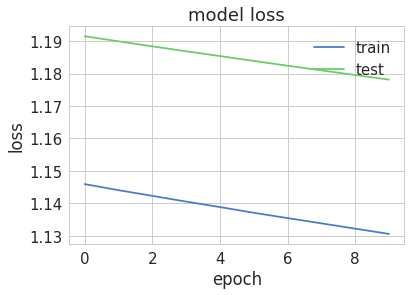

In [274]:
autoencoder = load_model('model.h5')

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [275]:
predictions = autoencoder.predict(test_features)

mse = np.mean(np.power(test_features - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': test_labels[:,1]})
error_df.describe()


,reconstruction_error,true_class
count,200000.000000,200000.000000
mean,1.084104,0.001885
std,9.032848,0.043376
min,0.128187,0.000000
25%,0.359143,0.000000
50%,0.614120,0.000000
75%,1.052403,0.000000
max,1960.600857,1.000000


### Reconstruction

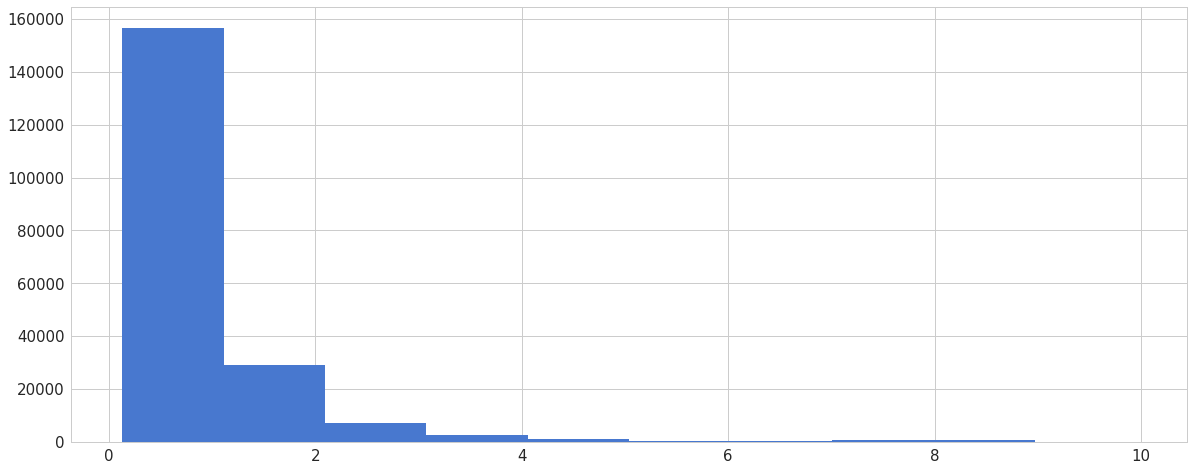

In [276]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

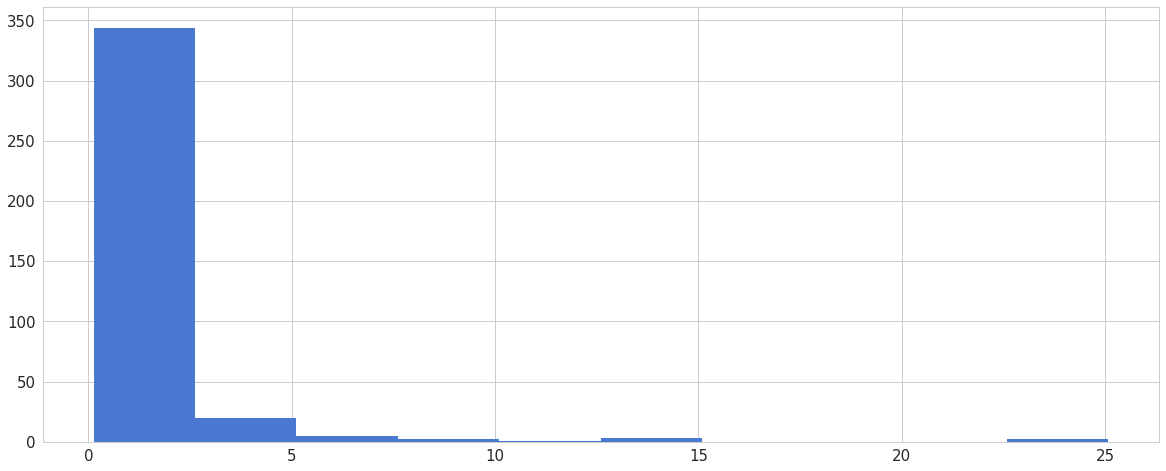

In [277]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

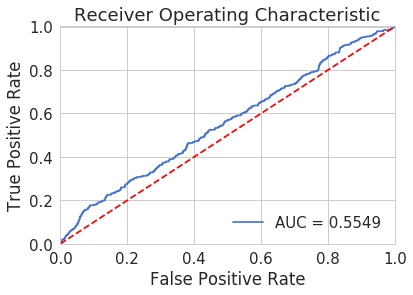

In [278]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

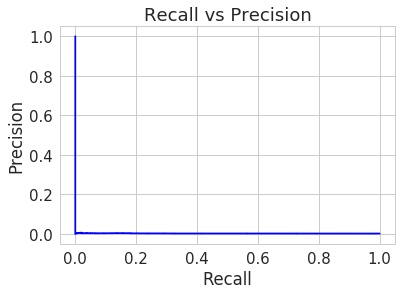

In [279]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

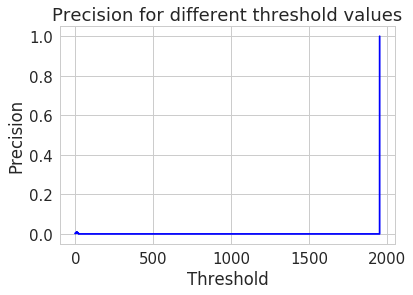

In [233]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

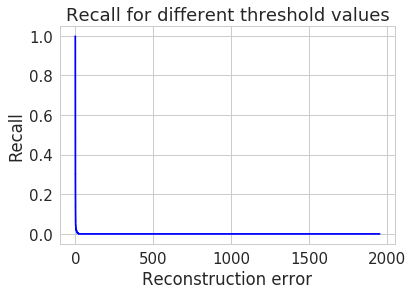

In [244]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [178]:
threshold = 2.5

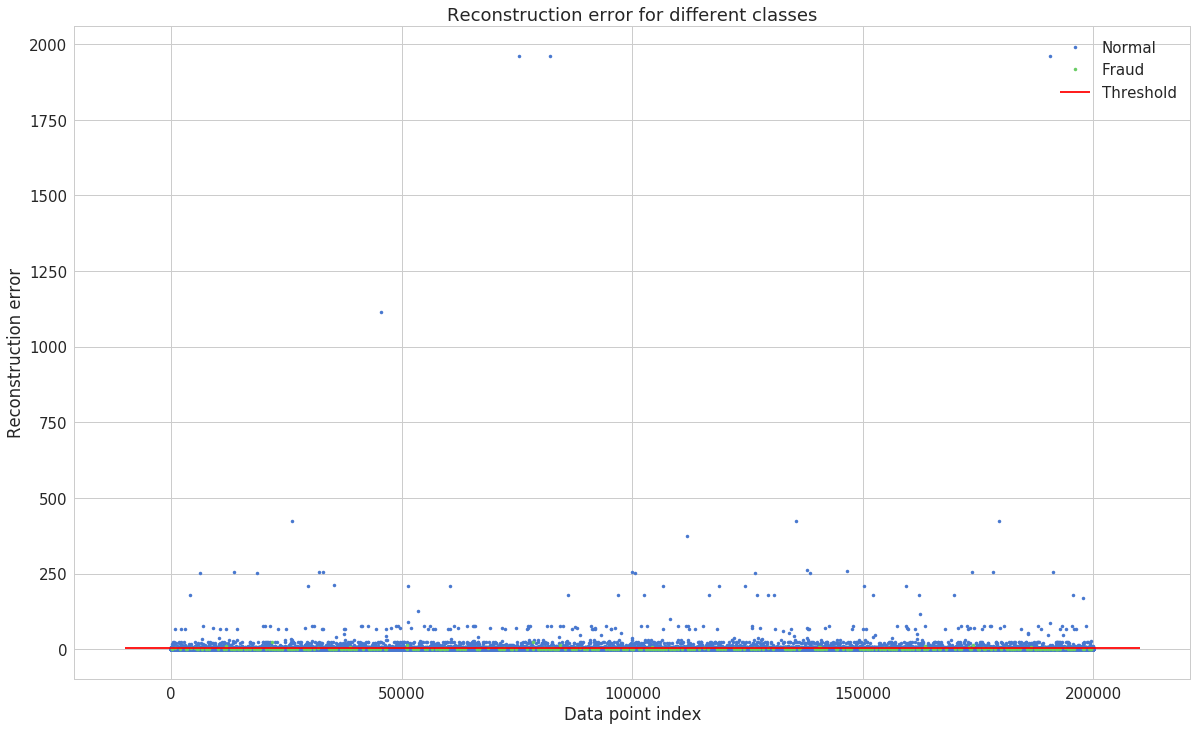

In [280]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(20, 12))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

f1 = 0.004
precision = [0.9986914  0.00202451], recall = [0.19497753 0.86472149]


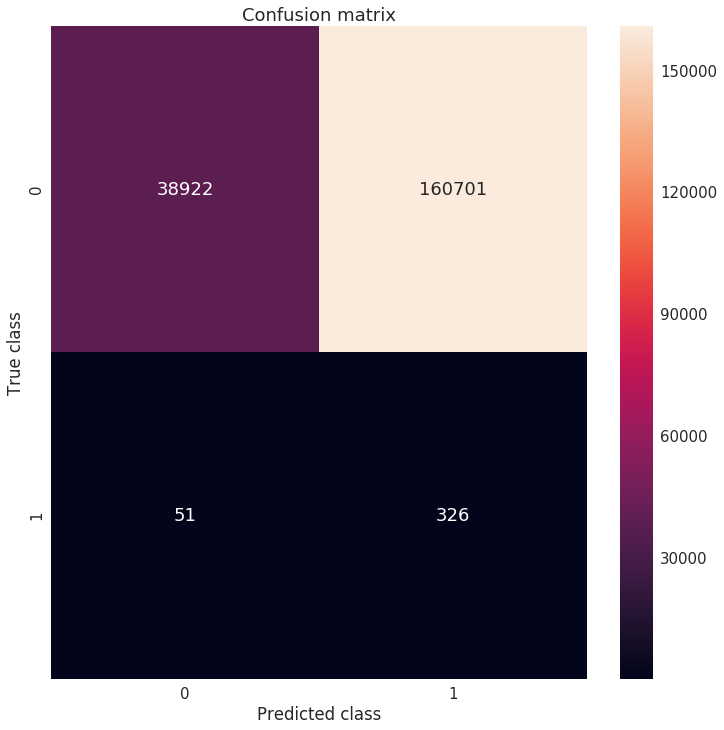

In [287]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

y_pred = [1 if e > 0.3 else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
f1 = f1_score(error_df.true_class, y_pred)

print("f1 = %0.3f" % f1)
precision, recall, _, _ = precision_recall_fscore_support(error_df.true_class, y_pred)

print("precision = {}, recall = {}".format(precision, recall))

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=['0', '1'], yticklabels=['0', '1'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Bagging

In [50]:
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from sklearn.utils import class_weight
from sklearn.feature_selection import VarianceThreshold

def shuffle(features, labels):
    p = np.random.permutation(len(features))
    return features[p], labels[p]

vt = VarianceThreshold(threshold=0.9)
transformed_features = vt.fit_transform(features)
selected_features_indices = vt.get_support(indices=True)

print(transformed_features.shape)

randomUnderSampler = RandomUnderSampler(ratio={0: 1531*100, 1: 1531}, random_state=KFOLD_SEED)
smote = SMOTE(n_jobs=-1, random_state=KFOLD_SEED)

undersampled_features, undersampled_labels = randomUnderSampler.fit_sample(
    transformed_features, labels[:,1])

undersampled_features, undersampled_labels = smote.fit_sample(
    undersampled_features, undersampled_labels)

shuffled_features, shuffled_labels = shuffle(
    undersampled_features, undersampled_labels)

shuffled_labels = keras.utils.to_categorical(shuffled_labels)

class_weight = class_weight.compute_class_weight('balanced', np.unique(
    shuffled_labels[:,1]), shuffled_labels[:,1])

print("class weight: {}".format(class_weight))

feature_count = shuffled_features.shape[1]
model = Sequential()
model.add(Dense(feature_count, input_shape=(feature_count,),
                kernel_regularizer=l2(0.01),
                kernel_initializer='glorot_uniform'))
# model.add(Dense(64, activation='tanh'))
# model.add(Dense(32, activation='tanh', kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.2))
# model.add(Dense(int(feature_count/2), activation='tanh'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

history = model.fit(shuffled_features, shuffled_labels,
                    batch_size=32,
                    class_weight={0: 1.5, 1: 1},
                    epochs=3,
                    callbacks=[keras.callbacks.EarlyStopping()],
                    validation_split=0.2,
                    verbose=1)

y_preds = model.predict(test_features[:,selected_features_indices], verbose=1)

rocauc_score = roc_auc_score(test_labels, y_preds)
print("ROC AUC score = %0.3f" % rocauc_score)

keras_confusion_matrix(test_labels, y_preds)
keras_f1_score(test_labels, y_preds)
keras_precision_recall(test_labels, y_preds)

(800000, 47)
class weight: [1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 47)                2256      
_________________________________________________________________
dense_107 (Dense)            (None, 2)                 96        
Total params: 2,352
Trainable params: 2,352
Non-trainable params: 0
_________________________________________________________________
Train on 244960 samples, validate on 61240 samples
Epoch 1/3
244960/244960 [==============================] - 49s 200us/step - loss: 0.9233 - acc: 0.6158 - val_loss: 0.7992 - val_acc: 0.6089
Epoch 2/3
244960/244960 [==============================] - 47s 193us/step - loss: 0.7814 - acc: 0.6160 - val_loss: 0.7803 - val_acc: 0.6259
Epoch 3/3
200000/200000 [==============================] - 14s 71us/step
ROC AUC score = 0.706
Confusion Matrix:
True Negative = 168171
False Negative = 217
True Positive

(array([0.99871131, 0.00506137]), array([0.84244301, 0.42440318]))

In [56]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_jobs=-1, verbose=1)
clf.fit(features, labels)

clf.feature_importances_ 

array([0.02494975, 0.01408007, 0.01049641, 0.00943332, 0.00939675,
       0.00888968, 0.01000574, 0.01046744, 0.00940389, 0.01091225,
       0.0103418 , 0.0087102 , 0.0105798 , 0.00983224, 0.00880471,
       0.00892732, 0.01335815, 0.00860344, 0.00941608, 0.00959272,
       0.00852495, 0.01188584, 0.00972788, 0.01037821, 0.01015014,
       0.01197132, 0.01378356, 0.0117626 , 0.00992054, 0.00910835,
       0.01018833, 0.00984432, 0.00919368, 0.00931039, 0.01005267,
       0.01154623, 0.00960289, 0.00945588, 0.00896719, 0.0094016 ,
       0.01092243, 0.01085012, 0.00865495, 0.00898575, 0.00838985,
       0.00931881, 0.00945567, 0.00903217, 0.01041278, 0.01188264,
       0.01130563, 0.01314528, 0.01187708, 0.01140477, 0.01054988,
       0.01371557, 0.0150267 , 0.01304728, 0.01624808, 0.0148901 ,
       0.0154982 , 0.01166772, 0.00974705, 0.01382105, 0.01446391,
       0.01217855, 0.01221253, 0.01148272, 0.01371827, 0.01273031,
       0.01175184, 0.01245588, 0.01307208, 0.01363387, 0.01204

In [58]:
from sklearn.feature_selection import SelectFromModel

selection_model = SelectFromModel(clf, prefit=True)
X_new = selection_model.transform(features)

In [61]:
print(X_new.shape)
print(selection_model.get_support(indices=True))

(800000, 40)
[ 0  1 16 21 25 26 27 35 49 51 52 53 55 56 57 58 59 60 61 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 78 80 81 82 83 86 87]


In [62]:
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from sklearn.utils import class_weight
from sklearn.feature_selection import VarianceThreshold

def shuffle(features, labels):
    p = np.random.permutation(len(features))
    return features[p], labels[p]

feature_indices = selection_model.get_support(indices=True)
randomUnderSampler = RandomUnderSampler(ratio={0: 1531*100, 1: 1531}, random_state=KFOLD_SEED)
smote = SMOTE(n_jobs=-1, random_state=KFOLD_SEED)

undersampled_features, undersampled_labels = randomUnderSampler.fit_sample(
    X_new, labels[:,1])

undersampled_features, undersampled_labels = smote.fit_sample(
    undersampled_features, undersampled_labels)

shuffled_features, shuffled_labels = shuffle(
    undersampled_features, undersampled_labels)

shuffled_labels = keras.utils.to_categorical(shuffled_labels)

class_weight = class_weight.compute_class_weight('balanced', np.unique(
    shuffled_labels[:,1]), shuffled_labels[:,1])

print("class weight: {}".format(class_weight))

feature_count = shuffled_features.shape[1]
model = Sequential()
model.add(Dense(feature_count, input_shape=(feature_count,),
                kernel_regularizer=l2(0.01),
                kernel_initializer='glorot_uniform'))
# model.add(Dense(64, activation='tanh'))
# model.add(Dense(32, activation='tanh', kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.2))
# model.add(Dense(int(feature_count/2), activation='tanh'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

history = model.fit(shuffled_features, shuffled_labels,
                    batch_size=32,
                    class_weight={0: 1.5, 1: 1},
                    epochs=3,
                    callbacks=[keras.callbacks.EarlyStopping()],
                    validation_split=0.2,
                    verbose=1)

y_preds = model.predict(test_features[:,feature_indices], verbose=1)

rocauc_score = roc_auc_score(test_labels, y_preds)
print("ROC AUC score = %0.3f" % rocauc_score)

keras_confusion_matrix(test_labels, y_preds)
keras_f1_score(test_labels, y_preds)
keras_precision_recall(test_labels, y_preds)

class weight: [1. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 40)                1640      
_________________________________________________________________
dense_122 (Dense)            (None, 2)                 82        
Total params: 1,722
Trainable params: 1,722
Non-trainable params: 0
_________________________________________________________________
Train on 244960 samples, validate on 61240 samples
Epoch 1/3
244960/244960 [==============================] - 51s 206us/step - loss: 0.9355 - acc: 0.5617 - val_loss: 0.8265 - val_acc: 0.5679
Epoch 2/3
244960/244960 [==============================] - 51s 208us/step - loss: 0.8154 - acc: 0.5635 - val_loss: 0.8095 - val_acc: 0.5606
Epoch 3/3
200000/200000 [==============================] - 16s 81us/step
ROC AUC score = 0.644
Confusion Matrix:
True Negative = 167939
False Negative = 258
True Positive = 119
False 

(array([0.99846608, 0.00374179]), array([0.84128081, 0.31564987]))